`Idea - from the center of the 3D mesh, look into every direction and record how far the surface is in tha direction. lay those distances out a 2D map`

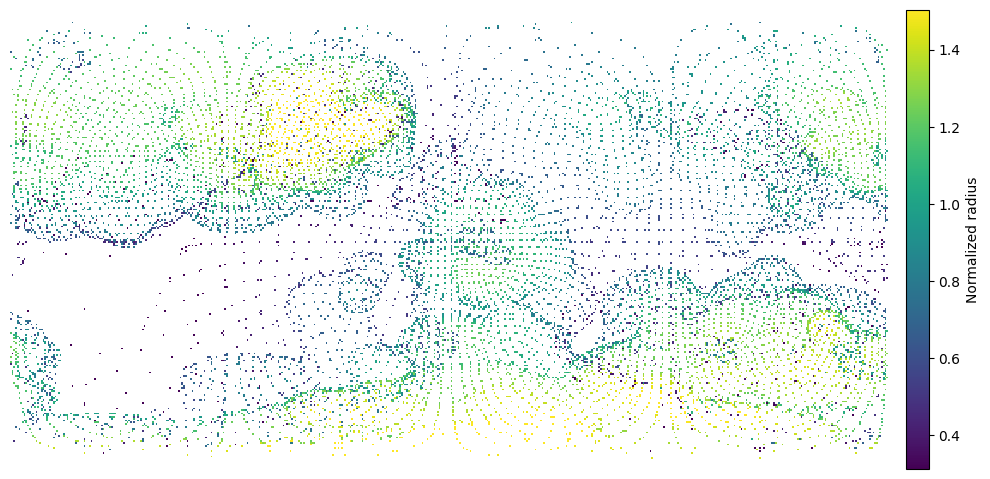

Saved:
  data/green_monkey/va_testing/chr1_12hrs_vacv_radius.png
  data/green_monkey/va_testing/chr1_12hrs_vacv_radius.npy
  data/green_monkey/va_testing/chr1_12hrs_vacv_radius_mask.npy


In [14]:
#   chr1_12hrs_vacv_metaball.obj
#
# Outputs:
#   chr1_12hrs_vacv_radius.png     (radius map image)
#   chr1_12hrs_vacv_radius.npy     (H×W float32 array; NaN where empty)
#   chr1_12hrs_vacv_radius_mask.npy (H×W bool mask of valid bins)

import numpy as np
import trimesh
import matplotlib.pyplot as plt
from typing import Optional, Dict
from dataclasses import dataclass

# ------------------------------- Data class -------------------------------
@dataclass
class SphereMap:
    radius: np.ndarray   # (H, W) float32, NaN where empty/no hit
    mask:   np.ndarray   # (H, W) bool
    meta:   Dict         # info: H,W, center, method, bins, norms, etc.

# ------------------------------- helpers ---------------------------------
def _angles_from_dirs(dirs: np.ndarray):
    """dirs: (N,3) unit vectors; returns theta in [0,pi], phi in [-pi,pi)."""
    x, y, z = dirs[:,0], dirs[:,1], dirs[:,2]
    theta = np.arccos(np.clip(z, -1.0, 1.0))               # polar (0 at +Z)
    phi = np.arctan2(y, x)                                 # azimuth
    return theta, phi

def _bin_angles(theta_v, phi_v, H, W):
    """Map vertex angles to integer bin indices (i,j)."""
    j = np.floor((phi_v + np.pi) / (2*np.pi) * W).astype(int)
    i = np.floor(theta_v / np.pi * H).astype(int)
    i = np.clip(i, 0, H-1); j = np.mod(j, W)
    return i, j

def _center_choice(mesh: trimesh.Trimesh, mode="mass"):
    try:
        if mode == "mass" and mesh.is_watertight:
            return mesh.center_mass
        return mesh.vertices.mean(axis=0)
    except Exception:
        return mesh.vertices.mean(axis=0)

# --------------------------- main computations ---------------------------
def radius_map_vertex(mesh: trimesh.Trimesh,
                      center: Optional[np.ndarray]=None,
                      H: int=256, W: int=512,
                      agg: str="median") -> SphereMap:
    """
    Bin vertices by (theta,phi) from a center; per-bin aggregate radius.
    agg: 'median' (recommended) or 'mean' or 'max'
    """
    if center is None:
        center = _center_choice(mesh)
    V = mesh.vertices - center
    r = np.linalg.norm(V, axis=1).astype(np.float32)
    # angles
    dirs_v = V / np.maximum(1e-12, r)[:,None]
    theta_v, phi_v = _angles_from_dirs(dirs_v)
    i, j = _bin_angles(theta_v, phi_v, H, W)

    # aggregate
    radius = np.full((H,W), np.nan, dtype=np.float32)
    if agg in ("median", "mean"):
        flat_ids = i * W + j
        order = np.argsort(flat_ids)
        flat_ids = flat_ids[order]; r_sorted = r[order]
        uniq, start_idx = np.unique(flat_ids, return_index=True)
        end_idx = np.r_[start_idx[1:], [len(flat_ids)]]
        for u, s, e in zip(uniq, start_idx, end_idx):
            ii = u // W; jj = u % W
            vals = r_sorted[s:e]
            if agg == "median":
                radius[ii, jj] = np.median(vals).astype(np.float32)
            else:
                radius[ii, jj] = vals.mean().astype(np.float32)
    elif agg == "max":
        for ii, jj, rv in zip(i, j, r):
            if np.isnan(radius[ii, jj]) or rv > radius[ii, jj]:
                radius[ii, jj] = rv
    else:
        raise ValueError("agg must be 'median', 'mean', or 'max'.")

    mask = ~np.isnan(radius)
    return SphereMap(radius=radius, mask=mask,
                     meta={"H":H,"W":W,"center":center,"method":"vertex-"+agg})

def normalize_radius(sm: SphereMap, mode="per_shape_median", ref_value=None):
    """
    mode:
      - 'none' : leave as is (absolute units)
      - 'per_shape_mean' : divide by mean radius over valid bins
      - 'per_shape_median' : divide by median radius (default)
      - 'ref' : divide by 'ref_value'
    """
    radius = sm.radius.copy()
    m = sm.mask
    if mode == "none":
        return radius
    vals = radius[m]
    if vals.size == 0:
        return radius
    if mode == "per_shape_mean":
        s = float(np.nanmean(vals))
        radius[m] = radius[m] / (s if s>0 else 1.0)
    elif mode == "per_shape_median":
        s = float(np.nanmedian(vals))
        radius[m] = radius[m] / (s if s>0 else 1.0)
    elif mode == "ref":
        if ref_value is None or ref_value <= 0:
            raise ValueError("ref_value must be positive for mode='ref'.")
        radius[m] = radius[m] / ref_value
    else:
        raise ValueError("Unknown normalization mode.")
    return radius

def save_map_png(array2d: np.ndarray, path: str, cmap="viridis",
                 vmin=None, vmax=None, mask: Optional[np.ndarray]=None):
    """Save an array as PNG; NaNs transparent; also show inline."""
    a = array2d.copy()
    if mask is not None:
        a = np.where(mask, a, np.nan)
    if vmin is None or vmax is None:
        finite = np.isfinite(a)
        if finite.any():
            vmin = np.nanpercentile(a[finite], 2)
            vmax = np.nanpercentile(a[finite], 98)
        else:
            vmin, vmax = 0.0, 1.0

    plt.figure(figsize=(10,5))
    im = plt.imshow(a, origin='upper', cmap=cmap, vmin=vmin, vmax=vmax, interpolation='nearest')
    plt.axis('off')
    cbar = plt.colorbar(im, fraction=0.025, pad=0.02)
    cbar.set_label('Normalized radius')
    plt.tight_layout()
    plt.savefig(path, dpi=150, transparent=True)
    plt.show()

# ------------------------------- run once --------------------------------
mesh_path = "data/green_monkey/all_structure_files/chr1/spatial_data/overall_shapes/chr1_12hrs_vacv_metaball.obj"
mesh = trimesh.load(mesh_path, process=False)

# Compute vertex-median radius map
sm = radius_map_vertex(mesh, H=256, W=512, agg="median")

# Normalize per-shape (median = 1.0) so values are comparable across time/condition later
arr = normalize_radius(sm, mode="per_shape_median")

# Save arrays and PNG; also display inline
np.save("data/green_monkey/va_testing/chr1_12hrs_vacv_radius.npy", arr.astype(np.float32))
np.save("data/green_monkey/va_testing/chr1_12hrs_vacv_radius_mask.npy", sm.mask)
save_map_png(arr, "data/green_monkey/va_testing/chr1_12hrs_vacv_radius_dots.png", cmap="viridis", mask=sm.mask)

print("Saved:")
print("  data/green_monkey/va_testing/chr1_12hrs_vacv_radius.png")
print("  data/green_monkey/va_testing/chr1_12hrs_vacv_radius.npy")
print("  data/green_monkey/va_testing/chr1_12hrs_vacv_radius_mask.npy")


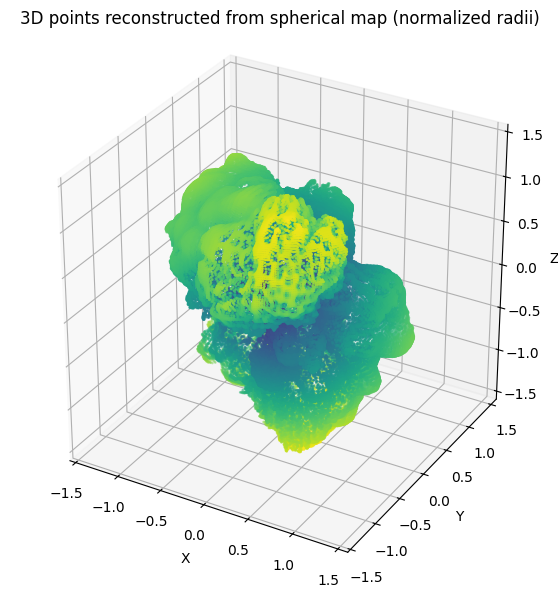

In [16]:
# 3D visualization of the spherical map as points (no files saved)

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

# --- sanity checks ---
if 'arr' not in globals() or 'sm' not in globals():
    raise RuntimeError("Please run the spherical map cell first so `arr` and `sm` exist.")

R = np.array(arr, dtype=float)      # normalized radii (median ~ 1.0)
M = np.array(sm.mask, dtype=bool)   # valid pixels
H, W = R.shape

# --- build directions for each pixel (theta: 0..pi, phi: -pi..pi) ---
eps = 1e-6
theta = np.linspace(eps, np.pi - eps, H, dtype=float)
phi   = np.linspace(-np.pi, np.pi, W, endpoint=False, dtype=float)
Th, Ph = np.meshgrid(theta, phi, indexing='ij')
st, ct = np.sin(Th), np.cos(Th)
cp, sp = np.cos(Ph), np.sin(Ph)
dirs = np.stack([st*cp, st*sp, ct], axis=-1)  # H×W×3 unit vectors

# --- reconstruct 3D points in a normalized coordinate system ---
# We use the normalized radius directly (so typical radius ~1). Center at the origin.
mask = M & np.isfinite(R)
X = (R[..., None] * dirs)[mask]  # N×3 points
C = R[mask]                      # values to color the points

# --- plot ---
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, projection='3d')

# Scatter the reconstructed surface points
ax.scatter(X[:,0], X[:,1], X[:,2], s=1.0, c=C)

# Make axes equal for a sphere-like view
max_range = (X.max(axis=0) - X.min(axis=0)).max()
mid = X.mean(axis=0)
ax.set_xlim(mid[0]-max_range/2, mid[0]+max_range/2)
ax.set_ylim(mid[1]-max_range/2, mid[1]+max_range/2)
ax.set_zlim(mid[2]-max_range/2, mid[2]+max_range/2)
ax.set_box_aspect((1,1,1))

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D points reconstructed from spherical map (normalized radii)')
plt.show()


Raycast engine not available here; using vertex map + spherical fill.


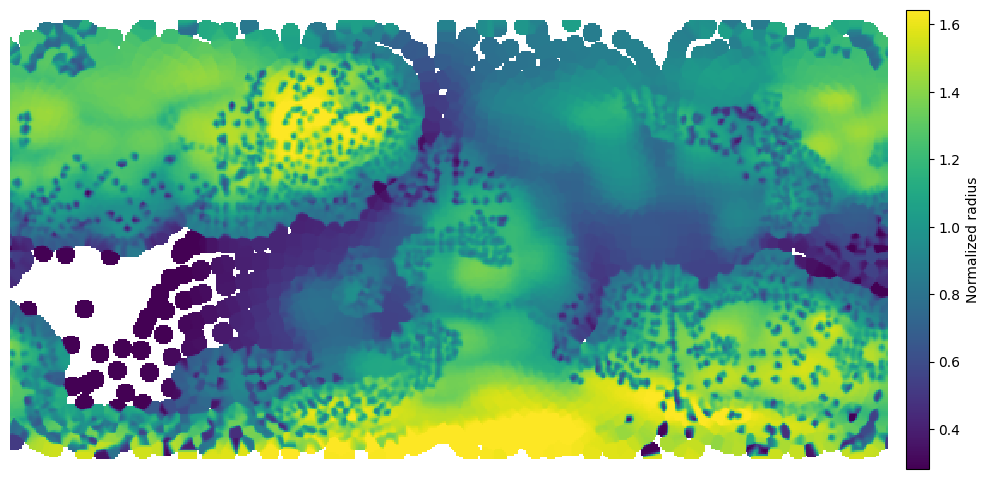

Saved:
  data/green_monkey/va_testing/chr1_12hrs_vacv_radius.png
  data/green_monkey/va_testing/chr1_12hrs_vacv_radius.npy
  data/green_monkey/va_testing/chr1_12hrs_vacv_radius_mask.npy
Method: vertex+fill


In [15]:
# --- Spherical Unfolding (raycast if available; otherwise filled-vertex) ---

import numpy as np
import trimesh
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import Optional, Dict
from scipy.ndimage import gaussian_filter

# ------------------------------- Data class -------------------------------
@dataclass
class SphereMap:
    radius: np.ndarray   # (H, W) float32, NaN where empty/no hit
    mask:   np.ndarray   # (H, W) bool
    meta:   Dict

# ------------------------------- helpers ---------------------------------
def _angles_from_dirs(dirs: np.ndarray):
    x, y, z = dirs[:,0], dirs[:,1], dirs[:,2]
    theta = np.arccos(np.clip(z, -1.0, 1.0))   # 0..pi
    phi = np.arctan2(y, x)                     # -pi..pi
    return theta, phi

def _bin_angles(theta_v, phi_v, H, W):
    j = np.floor((phi_v + np.pi) / (2*np.pi) * W).astype(int)
    i = np.floor(theta_v / np.pi * H).astype(int)
    i = np.clip(i, 0, H-1); j = np.mod(j, W)
    return i, j

def _center_choice(mesh: trimesh.Trimesh, mode="mass"):
    try:
        if mode == "mass" and mesh.is_watertight:
            return mesh.center_mass
        return mesh.vertices.mean(axis=0)
    except Exception:
        return mesh.vertices.mean(axis=0)

# NaN-aware Gaussian on a sphere-like grid (wrap in φ, clamp in θ)
def spherical_nan_gauss(a: np.ndarray, sigma_px: float) -> np.ndarray:
    if sigma_px <= 0: 
        return a.copy()
    valid = np.isfinite(a).astype(np.float32)
    a0 = np.nan_to_num(a, nan=0.0).astype(np.float32)
    num = gaussian_filter(a0,  sigma=(sigma_px, sigma_px), mode=('nearest','wrap'))
    den = gaussian_filter(valid, sigma=(sigma_px, sigma_px), mode=('nearest','wrap'))
    out = np.full_like(a0, np.nan, dtype=np.float32)
    m = den > 1e-6
    out[m] = num[m] / den[m]
    return out

# --------------------------- computations --------------------------------
def radius_map_vertex(mesh: trimesh.Trimesh, center=None, H=256, W=512, agg="median") -> SphereMap:
    if center is None: center = _center_choice(mesh)
    V = mesh.vertices - center
    r = np.linalg.norm(V, axis=1).astype(np.float32)
    dirs_v = V / np.maximum(1e-12, r)[:,None]
    theta_v, phi_v = _angles_from_dirs(dirs_v)
    i, j = _bin_angles(theta_v, phi_v, H, W)

    radius = np.full((H,W), np.nan, dtype=np.float32)
    if agg in ("median","mean"):
        flat = i*W + j
        order = np.argsort(flat)
        flat = flat[order]; r_sorted = r[order]
        uniq, start = np.unique(flat, return_index=True)
        end = np.r_[start[1:], [len(flat)]]
        for u, s, e in zip(uniq, start, end):
            ii = u // W; jj = u % W
            vals = r_sorted[s:e]
            radius[ii, jj] = (np.median(vals) if agg=="median" else np.mean(vals)).astype(np.float32)
    elif agg == "max":
        for ii, jj, rv in zip(i, j, r):
            if np.isnan(radius[ii,jj]) or rv > radius[ii,jj]:
                radius[ii,jj] = rv
    else:
        raise ValueError("agg must be median|mean|max")
    mask = np.isfinite(radius)
    return SphereMap(radius=radius, mask=mask, meta={"method":"vertex-"+agg, "center":center, "H":H, "W":W})

def radius_map_raycast(mesh: trimesh.Trimesh, center=None, H=256, W=512) -> Optional[SphereMap]:
    """Returns SphereMap if ray engines available, else None (so we can fall back)."""
    if center is None: center = _center_choice(mesh)
    eps = 1e-6
    theta = np.linspace(eps, np.pi-eps, H, dtype=np.float32)
    phi   = np.linspace(-np.pi, np.pi, W, endpoint=False, dtype=np.float32)
    Th, Ph = np.meshgrid(theta, phi, indexing='ij')
    st, ct = np.sin(Th), np.cos(Th)
    cp, sp = np.cos(Ph), np.sin(Ph)
    dirs = np.stack([st*cp, st*sp, ct], axis=-1).reshape(-1,3).astype(np.float32)
    dirs /= np.linalg.norm(dirs, axis=1, keepdims=True)
    origins = np.repeat(center[None,:], H*W, axis=0).astype(np.float32)

    # Try pyembree first
    try:
        from trimesh.ray import ray_pyembree
        inter = ray_pyembree.RayMeshIntersector(mesh)
        d = inter.intersects_first(origins, dirs)    # NaN for miss
        radius = d.reshape(H, W).astype(np.float32)
        mask = np.isfinite(radius)
        return SphereMap(radius=radius, mask=mask, meta={"method":"ray-pyembree","center":center,"H":H,"W":W})
    except Exception:
        pass

    # Try generic ray engine (needs rtree). If missing, we bail.
    try:
        loc, idx, _ = mesh.ray.intersects_location(origins, dirs, multiple_hits=False)
        radius = np.full((H*W,), np.nan, dtype=np.float32)
        if len(idx):
            delta = loc - origins[idx]
            dist = np.linalg.norm(delta, axis=1).astype(np.float32)
            radius[idx] = dist
        radius = radius.reshape(H, W)
        mask = np.isfinite(radius)
        return SphereMap(radius=radius, mask=mask, meta={"method":"ray-generic","center":center,"H":H,"W":W})
    except Exception:
        return None  # environment lacks rtree; caller will fall back

def normalize_radius(sm: SphereMap, mode="per_shape_median", ref_value=None):
    radius = sm.radius.copy()
    m = sm.mask
    if mode == "none": return radius
    vals = radius[m]
    if vals.size == 0: return radius
    if mode == "per_shape_mean":
        s = float(np.nanmean(vals))
    elif mode == "per_shape_median":
        s = float(np.nanmedian(vals))
    elif mode == "ref":
        if ref_value is None or ref_value <= 0:
            raise ValueError("ref_value must be positive for mode='ref'")
        s = float(ref_value)
    else:
        raise ValueError("Unknown normalization mode.")
    if s > 0: radius[m] = radius[m] / s
    return radius

def save_map_png(array2d: np.ndarray, path: str, mask: Optional[np.ndarray]=None,
                 cmap="viridis", facecolor="white", dpi=200):
    a = array2d.copy()
    if mask is not None:
        a = np.where(mask, a, np.nan)
    # Robust range
    finite = np.isfinite(a)
    vmin = np.nanpercentile(a[finite], 2) if finite.any() else 0.0
    vmax = np.nanpercentile(a[finite], 98) if finite.any() else 1.0

    plt.figure(figsize=(10,5))
    im = plt.imshow(a, origin='upper', cmap=cmap, vmin=vmin, vmax=vmax, interpolation='nearest')
    plt.axis('off')
    cbar = plt.colorbar(im, fraction=0.025, pad=0.02)
    cbar.set_label('Normalized radius')
    plt.tight_layout()
    plt.savefig(path, dpi=dpi, transparent=False, facecolor=facecolor, bbox_inches="tight", pad_inches=0.02)
    plt.show()

# ------------------------------- RUN -------------------------------------
# paths (yours)
mesh_path = "data/green_monkey/all_structure_files/chr1/spatial_data/overall_shapes/chr1_12hrs_vacv_metaball.obj"
out_base  = "data/green_monkey/va_testing/chr1_12hrs_vacv_radius"

H, W = 256, 512
FILL_SIGMA = 1.2   # px; used only if we need to fill vertex holes (no ray available)

mesh = trimesh.load(mesh_path, process=False)
center = _center_choice(mesh)

# Try raycast first
sm = radius_map_raycast(mesh, center=center, H=H, W=W)

if sm is None:
    # Fall back: vertex map, then fill by NaN-aware spherical blur
    print("Raycast engine not available here; using vertex map + spherical fill.")
    sm_v = radius_map_vertex(mesh, center=center, H=H, W=W, agg="median")
    filled = spherical_nan_gauss(sm_v.radius, FILL_SIGMA)
    sm = SphereMap(radius=filled, mask=np.isfinite(filled),
                   meta={"method":"vertex+fill","center":center,"H":H,"W":W})

# Normalize (per-shape median -> 1.0)
arr = normalize_radius(sm, mode="per_shape_median")

# Save arrays & PNG
np.save(out_base + ".npy", arr.astype(np.float32))
np.save(out_base + "_mask.npy", sm.mask)
save_map_png(arr, out_base + ".png", mask=sm.mask, cmap="viridis", facecolor="white", dpi=220)

print("Saved:")
print(" ", out_base + ".png")
print(" ", out_base + ".npy")
print(" ", out_base + "_mask.npy")
print("Method:", sm.meta.get("method"))

